# Project: SQLite Upload, Join Tables and Agg Functions (CIA Factbook)

<br>

## Questions to address:
- Create a database with both CIA facts on countries and information about the cities on those countries
- Check which entreis in the CIA facts table have no cities
- Select capitals with more than 5 million habitants and show them on a map
- Look at the countries with the highest percentage of urban population

<br>

## Tools:
- import os: os.remove(./file.txt)
- import shutil: shutil.copy(src_file, dst_file)
- load table into SQL database using pandas: df.to_sql
- INNER JOIN table_1 ON table_2.col_A = table_1.col_B 
- LEFT JOIN
- subqueries
- aggregate functions
- df.merge()
- CAST

<br>

### load defaults

In [4]:
import sqlite3
import pandas as pd
import re
import numpy as np
import requests 
import os
import shutil

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))

<br>

## Dataset: CIA World Factbook about country demographics in 2015 

We will modify the original database so the first thing to do is to copy the original into a new file

In [9]:
try:
    os.remove("./data/factbook.db")
    print("file removed")
except:
    print("file not present")
    
shutil.copy("./data/factbook_original.db", "./data/factbook.db")
print("copy created")

file removed
copy created


<br>

## Analysis

<br>

### Q1: Load table into SQL database using Pandas

In [11]:
import sqlite3
import pandas as pd
from IPython.display import display

conn = sqlite3.connect('./data/factbook.db')

df = pd.read_csv('./data/cities.csv')
df.columns=["id", "name", "population", "capital", "facts_id"]
df.to_sql('cities', conn, if_exists='replace', index=False)

query = 'select * from cities'
df = pd.read_sql_query(query, conn)
display(df[:3])

,id,name,population,capital,facts_id
0,1,Oranjestad,37000,1,216
1,2,Saint John'S,27000,1,6
2,3,Abu Dhabi,942000,1,184


<br>

### Q2: INNER JOIN facts with the new cities table (which has a facts_id column)</b>

The INNER JOIN only includes rows where there is a match of IDs between the two tables

In [25]:
query = '''select * from facts 
       INNER JOIN cities ON facts.id = cities.facts_id 
            Limit 10'''

df = pd.read_sql_query(query, conn)
display(df.iloc[:4,[0,5,8,9,10,13,14,15,16,17]])

,id,area_water,birth_rate,death_rate,migration_rate,id,name,population,capital,facts_id
0,216,0,12.56,8.18,8.92,1,Oranjestad,37000,1,216
1,6,0,15.85,5.69,2.21,2,Saint John'S,27000,1,6
2,184,0,15.43,1.97,12.36,3,Abu Dhabi,942000,1,184
3,184,0,15.43,1.97,12.36,4,Dubai,1978000,0,184


- This allows us to get a table with information on the country and its cities

<br>

### Q3: INNER JOIN facts and cities selecting only capitals

In [28]:
query = """select f.name as country, c.name as capital_city from facts f
           INNER JOIN cities c on f.id = c.facts_id
           where c.capital=1"""
df = pd.read_sql_query(query, conn)
display(df.iloc[:3])

,country,capital_city
0,Aruba,Oranjestad
1,Antigua and Barbuda,Saint John'S
2,United Arab Emirates,Abu Dhabi


<br>

### Q4: Check Non Matches with a LEFT JOIN

- The LEFT JOIN includes all rows from table_1 and matches from table 2. 
- If we then check for rows where a variable from the second table is NULL this will give us the non matches (rows in table 2 that did not match the join condition)

In [32]:
query = """select f.name as country, f.population from facts f
           LEFT JOIN cities c on f.id = c.facts_id
           where c.name IS NULL"""
df = pd.read_sql_query(query, conn)
display(df[:9])

,country,population
0,Kosovo,1870981.0
1,Monaco,30535.0
2,Nauru,9540.0
3,San Marino,33020.0
4,Singapore,5674472.0
5,Holy See (Vatican City),842.0
6,Zimbabwe,14229541.0
7,Taiwan,23415126.0
8,European Union,513949445.0


- The Non matches are rows from the facts table that have no cities (e.g. Principates)

<br>

### Q5: Select capitals with more than 5 million habitants and show on a map

In [134]:
query = """select c.name as capital_city,
                  f.name as country,
                  c.population as population
             from facts f
       Inner Join (
                   select * from cities 
                    where capital = 1 and population>5000000
                  ) c on f.id = c.facts_id
         order by 3 desc"""
df = pd.read_sql_query(query, conn)
display(df[:9])

,capital_city,country,population
0,Tokyo,Japan,37217000
1,New Delhi,India,22654000
2,Mexico City,Mexico,20446000
3,Beijing,China,15594000
4,Dhaka,Bangladesh,15391000
5,Buenos Aires,Argentina,13528000
6,Manila,Philippines,11862000
7,Moscow,Russia,11621000
8,Cairo,Egypt,11169000


Get coordinates from './data/worldcities.csv' and combine dataframes

In [135]:
world_cities = pd.read_csv('./data/worldcities.csv', encoding='Latin-1')
cols = ['city','lat','lng','country','population']
cities = world_cities[cols]
capitals = cities.loc[world_cities['capital']=='primary']

#strip the spaces to be able to merge dataframes
df.loc[:, 'capital_city'] = df['capital_city'].apply(lambda x: x.strip())

combined_df = df.merge(capitals, left_on='capital_city', right_on='city', how='left')
combined_df['country'] = combined_df['country_x']
combined_df['population'] = combined_df['population_x']
combined_df.drop(['country_x', 'country_y', 'population_x', 'population_y'], axis=1, inplace=True)

#display(combined_df[:])

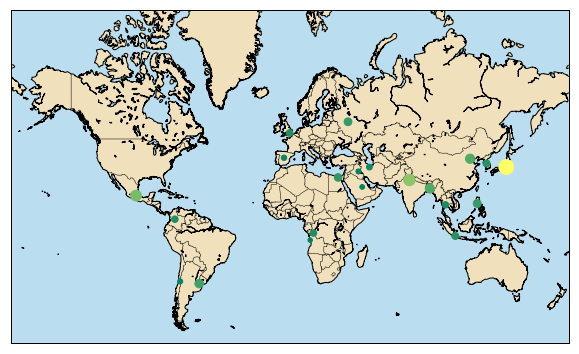

In [137]:
from mpl_toolkits.basemap import Basemap

fig, ax = plt.subplots(figsize=(10,10))
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=80, llcrnrlon=-180, urcrnrlon=180, resolution='l')
m.drawcoastlines()
m.fillcontinents(color='#F0E0BB', lake_color='#BBDDF0')
m.drawmapboundary(fill_color='#BBDDF0')
m.drawcountries(linewidth=0.5)

longitudes = combined_df['lng'].tolist()
latitudes = combined_df['lat'].tolist()
population = combined_df['population']
re_scaled_pop = convert_range_01(population)
m.scatter(longitudes, latitudes, s=(re_scaled_pop+0.1)*200, zorder=2, latlon=True, c=population, cmap='summer')

plt.show()

<br>

### Q6: Get stats on urban population for different countries

In [146]:
query = """select f.name as country, 
                  c.population as urban_pop, 
                  f.population as total_pop,  
                  CAST(c.population as float)/CAST(f.population as float)  as urban_pct
             from facts f
             
       Inner join (
                   select facts_id, 
                   sum(population) as population 
                   from cities 
          group by facts_id              
                 ) c on f.id = c.facts_id
                 
             where urban_pct > 0.0 and urban_pct<1.0
          ORDER by 4 DESC"""
df = pd.read_sql_query(query, conn)
display(df[:2])

,country,urban_pop,total_pop,urban_pct
0,Saint Pierre and Miquelon,5000,5657,0.883861
1,Kuwait,2406000,2788534,0.862819


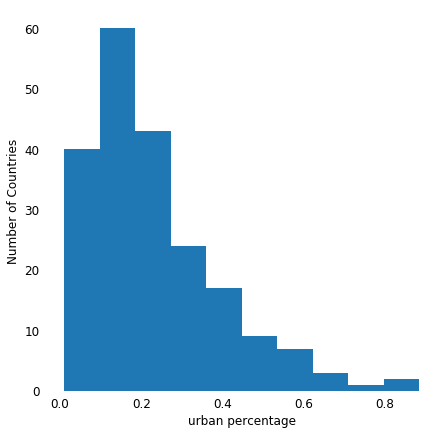

In [148]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot()

ax.hist(df['urban_pct'])

for key, spine in ax.spines.items():
        spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
ax.set_xlabel('urban percentage'), ax.set_ylabel('Number of Countries')
plt.show()